## Imports

In [1]:
# General imports 
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
from tqdm import tqdm
import tempfile
import csv
import requests as r
from Bio import SeqIO
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## Set Parameters of Analysis

In [2]:
analysis_threshold = 20 # number of amino acids either side to analyze

modifications = ["649.3660", "655.3735"] # which modifications we are looking for, as regex strings
heavy_modification = "655.3735" 
light_modification = "649.3660"

In [3]:
# path for csv output data
datasets_path_str = "../datasets/"
datasets_path = os.path.abspath(datasets_path_str)
print(datasets_path)

/Users/ritwiksrinivas/Desktop/Projects/methionine-analysis/datasets


In [4]:
cols_to_visualize = ['nAA_2_180_pae', 'nAA_3_180_pae', 'nAA_4_180_pae', 'nAA_4.5_180_pae', 'nAA_5_180_pae',
                     'nAA_5.5_180_pae', 'nAA_6_180_pae', 'nAA_6.5_180_pae', 'nAA_7_180_pae', 'nAA_7.5_180_pae', 
                     'nAA_8_180_pae', 'nAA_12_180_pae', 'nAA_18_180_pae', 'nAA_24_180_pae', 'nAA_12_70_pae', 
                     'nAA_2_180_pae_smooth10', 'nAA_3_180_pae_smooth10', 'nAA_4_180_pae_smooth10',
                     'nAA_4.5_180_pae_smooth10', 'nAA_5_180_pae_smooth10', 'nAA_5.5_180_pae_smooth10', 
                     'nAA_6_180_pae_smooth10', 'nAA_6.5_180_pae_smooth10', 'nAA_7_180_pae_smooth10',
                     'nAA_7.5_180_pae_smooth10', 'nAA_8_180_pae_smooth10', 'nAA_12_180_pae_smooth10', 
                     'nAA_18_180_pae_smooth10', 'nAA_24_180_pae_smooth10', 'nAA_12_70_pae_smooth10', 
                     'IDR']

# Experimental Peptides Analysis Playground

In [5]:
path = os.path.join(datasets_path, "RvsS_peptides_with_alphafold.csv")
experimental_peptides = pd.read_csv(path)
experimental_peptides.set_index("Unnamed: 0", inplace=True)
experimental_peptides.index.name = None
experimental_peptides

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,nAA_6_180_pae_smooth10,nAA_6.5_180_pae_smooth10,nAA_7_180_pae_smooth10,nAA_7.5_180_pae_smooth10,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,2.380952,3.666667,4.857143,6.190476,7.857143,22.190476,59.952381,120.857143,6.285714,0
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,2.761905,4.857143,6.285714,8.047619,9.047619,30.571429,90.857143,176.571429,8.285714,0
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,2.238095,3.285714,4.380952,5.238095,5.523810,11.238095,29.571429,61.952381,2.380952,0
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,2.095238,3.238095,4.428571,5.380952,5.952381,13.380952,27.047619,48.190476,3.047619,0
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,2.857143,4.238095,6.095238,7.380952,8.904762,27.523810,85.285714,171.619048,7.809524,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,2.523810,3.380952,4.428571,6.095238,7.666667,16.476190,42.238095,79.904762,2.380952,0
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,2.000000,2.904762,3.238095,4.000000,4.238095,7.190476,12.523810,19.428571,0.857143,1
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,2.857143,5.285714,6.238095,8.476190,8.952381,26.095238,62.571429,115.380952,7.571429,0
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,2.571429,3.428571,4.904762,6.761905,8.190476,25.952381,80.380952,173.428571,7.190476,0


In [6]:
experimental_peptides["loc_id"] = experimental_peptides["protein_id"] + "-" + experimental_peptides["position"].astype(str)
experimental_peptides = experimental_peptides.drop_duplicates(subset=['loc_id'])
experimental_peptides

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,nAA_6.5_180_pae_smooth10,nAA_7_180_pae_smooth10,nAA_7.5_180_pae_smooth10,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR,loc_id
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,3.666667,4.857143,6.190476,7.857143,22.190476,59.952381,120.857143,6.285714,0,Q8C196-584
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,4.857143,6.285714,8.047619,9.047619,30.571429,90.857143,176.571429,8.285714,0,Q07417-264
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,3.285714,4.380952,5.238095,5.523810,11.238095,29.571429,61.952381,2.380952,0,Q91YI0-20
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,3.238095,4.428571,5.380952,5.952381,13.380952,27.047619,48.190476,3.047619,0,P50247-418
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,4.238095,6.095238,7.380952,8.904762,27.523810,85.285714,171.619048,7.809524,0,P33267-364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,3.380952,4.428571,6.095238,7.666667,16.476190,42.238095,79.904762,2.380952,0,Q9QXF8-215
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,2.904762,3.238095,4.000000,4.238095,7.190476,12.523810,19.428571,0.857143,1,Q8K3J1-49
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,5.285714,6.238095,8.476190,8.952381,26.095238,62.571429,115.380952,7.571429,0,P63038-144
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,3.428571,4.904762,6.761905,8.190476,25.952381,80.380952,173.428571,7.190476,0,Q8BMS1-505


Visualizing Column: nAA_7_180_pae


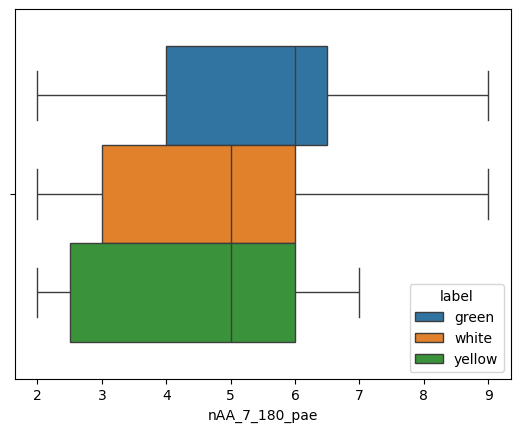

In [7]:
# visualize the distribution of crowdedness for a particular radius
col = 8
print(f"Visualizing Column: {cols_to_visualize[col]}")

sns.boxplot(data=experimental_peptides, x=cols_to_visualize[col], hue="label");

In [8]:
experimental_peptides.groupby("label")[cols_to_visualize].agg(np.mean)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_79883/3163227360.py:1: FutureWarning: The provided callable <function mean at 0x106a8c4c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  experimental_peptides.groupby("label")[cols_to_visualize].agg(np.mean)


,nAA_2_180_pae,nAA_3_180_pae,nAA_4_180_pae,nAA_4.5_180_pae,nAA_5_180_pae,nAA_5.5_180_pae,nAA_6_180_pae,nAA_6.5_180_pae,nAA_7_180_pae,nAA_7.5_180_pae,...,nAA_6_180_pae_smooth10,nAA_6.5_180_pae_smooth10,nAA_7_180_pae_smooth10,nAA_7.5_180_pae_smooth10,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR
label,,,,,,,,,,,,,,,,,,,,,
green,0.0,0.0,0.0,0.0,1.974359,2.051282,2.461538,4.256410,5.435897,7.025641,...,2.403541,4.069597,5.401709,6.815629,7.566545,18.932234,51.292430,97.417582,5.025641,0.025641
white,0.0,0.0,0.0,0.0,1.855932,1.906780,2.271186,3.745763,4.737288,5.932203,...,2.282898,3.591403,4.641108,5.865577,6.608471,16.418363,44.623301,85.289980,4.185707,0.177966
yellow,0.0,0.0,0.0,0.0,1.842105,1.842105,2.210526,3.578947,4.315789,5.368421,...,2.350877,3.739348,4.629073,5.982456,6.779449,17.187970,43.353383,79.694236,4.293233,0.210526


In [9]:
experimental_peptides.groupby("label")[cols_to_visualize].agg(np.median)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_79883/1746058152.py:1: FutureWarning: The provided callable <function median at 0x106bebee0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  experimental_peptides.groupby("label")[cols_to_visualize].agg(np.median)


,nAA_2_180_pae,nAA_3_180_pae,nAA_4_180_pae,nAA_4.5_180_pae,nAA_5_180_pae,nAA_5.5_180_pae,nAA_6_180_pae,nAA_6.5_180_pae,nAA_7_180_pae,nAA_7.5_180_pae,...,nAA_6_180_pae_smooth10,nAA_6.5_180_pae_smooth10,nAA_7_180_pae_smooth10,nAA_7.5_180_pae_smooth10,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR
label,,,,,,,,,,,,,,,,,,,,,
green,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,6.0,7.0,...,2.285714,4.142857,5.523810,7.000000,7.619048,18.523810,50.142857,96.238095,4.952381,0.0
white,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,5.0,6.0,...,2.238095,3.523810,4.738095,6.142857,6.928571,16.500000,47.904762,92.809524,4.047619,0.0
yellow,0.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0,5.0,6.0,...,2.285714,3.523810,4.428571,6.095238,7.000000,16.095238,40.238095,76.952381,3.285714,0.0


In [10]:
experimental_peptides.groupby(["label", "structure_group"]).agg("count").rename({"Peptide Sequence": "Count"}, axis=1)[["Count"]]

Count
label  structure_group       
green  BEND                 5
       HELX                23
       STRN                 7
       TURN                 3
       unstructured         1
white  BEND                10
       HELX                68
       STRN                14
       TURN                10
       unstructured        16
yellow BEND                 2
       HELX                10
       STRN                 3
       TURN                 3
       unstructured         1

In [11]:
# ttest for crowdedness at a particular radius - green vs. white
# statistically significant radii: 7, 7.5, 8, 12, 18, 12_70, 5_smooth, 5.5_smooth, 6_smooth, 6.5_smooth, 7_smooth, 7.5_smooth, 8_smooth, 12_smooth, 12_70_smooth, IDR

col = 10
print(f"T-Test for Column: {cols_to_visualize[col]}")

green = experimental_peptides[experimental_peptides['label'] == 'green'][cols_to_visualize[col]]
white = experimental_peptides[experimental_peptides['label'] == 'white'][cols_to_visualize[col]]

scipy.stats.ttest_ind(green, white)

T-Test for Column: nAA_8_180_pae


TtestResult(statistic=2.973680114375059, pvalue=0.003413408985289365, df=155.0)

In [12]:
# ttest for crowdedness at a particular radius - yellow vs. white
# statistically significant radii: 4.5_smooth 

col = 18
print(f"T-Test for Column: {cols_to_visualize[col]}")

yellow = experimental_peptides[experimental_peptides['label'] == 'yellow'][cols_to_visualize[col]]
white = experimental_peptides[experimental_peptides['label'] == 'white'][cols_to_visualize[col]]

scipy.stats.ttest_ind(yellow, white)

T-Test for Column: nAA_4.5_180_pae_smooth10


TtestResult(statistic=2.7280234903835257, pvalue=0.007219369549976999, df=135.0)

In [13]:
# ttest for crowdedness at a particular radius - green vs. yellow
# statistically significant radii: 7, 7.5, 8, 5_smooth, 5.5_smooth, 7_smooth, 7.5_smooth, IDR

col = 10
print(f"T-Test for Column: {cols_to_visualize[col]}")

green = experimental_peptides[experimental_peptides['label'] == 'green'][cols_to_visualize[col]]
yellow = experimental_peptides[experimental_peptides['label'] == 'yellow'][cols_to_visualize[col]]

scipy.stats.ttest_ind(green, yellow)

T-Test for Column: nAA_8_180_pae


TtestResult(statistic=3.0944819364339153, pvalue=0.003075103273178748, df=56.0)

In [14]:
experimental_peptides["pro_chiral"] = experimental_peptides["label"].apply(lambda label: '0' if label == "white" else '1')

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_79883/1435101664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experimental_peptides["pro_chiral"] = experimental_peptides["label"].apply(lambda label: '0' if label == "white" else '1')


Visualizing Column: nAA_7.5_180_pae


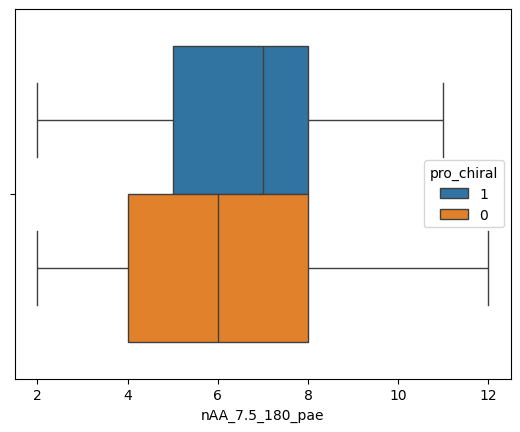

In [15]:
# visualize the distribution of crowdedness for a particular radius
col = 9
print(f"Visualizing Column: {cols_to_visualize[col]}")

sns.boxplot(data=experimental_peptides, x=cols_to_visualize[col], hue="pro_chiral");

In [16]:
experimental_peptides.groupby("pro_chiral")[cols_to_visualize].agg(np.mean)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_79883/1728963321.py:1: FutureWarning: The provided callable <function mean at 0x106a8c4c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  experimental_peptides.groupby("pro_chiral")[cols_to_visualize].agg(np.mean)


,nAA_2_180_pae,nAA_3_180_pae,nAA_4_180_pae,nAA_4.5_180_pae,nAA_5_180_pae,nAA_5.5_180_pae,nAA_6_180_pae,nAA_6.5_180_pae,nAA_7_180_pae,nAA_7.5_180_pae,...,nAA_6_180_pae_smooth10,nAA_6.5_180_pae_smooth10,nAA_7_180_pae_smooth10,nAA_7.5_180_pae_smooth10,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR
pro_chiral,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,1.855932,1.906780,2.271186,3.745763,4.737288,5.932203,...,2.282898,3.591403,4.641108,5.865577,6.608471,16.418363,44.623301,85.289980,4.185707,0.177966
1,0.0,0.0,0.0,0.0,1.931034,1.982759,2.379310,4.034483,5.068966,6.482759,...,2.386289,3.961412,5.148604,6.542693,7.308703,18.360837,48.691708,91.611658,4.785714,0.086207


In [17]:
experimental_peptides.groupby("pro_chiral")[cols_to_visualize].agg(np.median)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_79883/37853205.py:1: FutureWarning: The provided callable <function median at 0x106bebee0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  experimental_peptides.groupby("pro_chiral")[cols_to_visualize].agg(np.median)


,nAA_2_180_pae,nAA_3_180_pae,nAA_4_180_pae,nAA_4.5_180_pae,nAA_5_180_pae,nAA_5.5_180_pae,nAA_6_180_pae,nAA_6.5_180_pae,nAA_7_180_pae,nAA_7.5_180_pae,...,nAA_6_180_pae_smooth10,nAA_6.5_180_pae_smooth10,nAA_7_180_pae_smooth10,nAA_7.5_180_pae_smooth10,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR
pro_chiral,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,5.0,6.0,...,2.238095,3.523810,4.738095,6.142857,6.928571,16.500000,47.904762,92.809524,4.047619,0.0
1,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,5.5,7.0,...,2.285714,4.071429,5.380952,6.857143,7.595238,17.928571,48.166667,93.833333,4.666667,0.0


In [18]:
# ttest for crowdedness at a particular radius - green & yellow vs. white (i.e. pro-chiral vs. not)
# statistically significant radii: 4.5_smooth, 6_smooth, 6.5_smooth, 7_smooth, 7.5_smooth, 8_smooth, 

col = 22
print(f"T-Test for Column: {cols_to_visualize[col]}")

pro_chiral = experimental_peptides[experimental_peptides['pro_chiral'] == '1'][cols_to_visualize[col]]
not_pro_chiral = experimental_peptides[experimental_peptides['pro_chiral'] == '0'][cols_to_visualize[col]]

scipy.stats.ttest_ind(pro_chiral, not_pro_chiral)

T-Test for Column: nAA_6.5_180_pae_smooth10


TtestResult(statistic=2.9152375377735873, pvalue=0.004021972690415704, df=174.0)

# Experimental Peptides vs. Full Proteome Analysis Playground

In [19]:
path = os.path.join(datasets_path, "RvsS_peptides_with_alphafold.csv")
experimental_peptides = pd.read_csv(path)
experimental_peptides.set_index("Unnamed: 0", inplace=True)
experimental_peptides.index.name = None
experimental_peptides

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,nAA_6_180_pae_smooth10,nAA_6.5_180_pae_smooth10,nAA_7_180_pae_smooth10,nAA_7.5_180_pae_smooth10,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,2.380952,3.666667,4.857143,6.190476,7.857143,22.190476,59.952381,120.857143,6.285714,0
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,2.761905,4.857143,6.285714,8.047619,9.047619,30.571429,90.857143,176.571429,8.285714,0
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,2.238095,3.285714,4.380952,5.238095,5.523810,11.238095,29.571429,61.952381,2.380952,0
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,2.095238,3.238095,4.428571,5.380952,5.952381,13.380952,27.047619,48.190476,3.047619,0
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,2.857143,4.238095,6.095238,7.380952,8.904762,27.523810,85.285714,171.619048,7.809524,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,2.523810,3.380952,4.428571,6.095238,7.666667,16.476190,42.238095,79.904762,2.380952,0
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,2.000000,2.904762,3.238095,4.000000,4.238095,7.190476,12.523810,19.428571,0.857143,1
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,2.857143,5.285714,6.238095,8.476190,8.952381,26.095238,62.571429,115.380952,7.571429,0
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,2.571429,3.428571,4.904762,6.761905,8.190476,25.952381,80.380952,173.428571,7.190476,0


In [20]:
path = os.path.join(datasets_path, "RvsS_full_mitochondrial_with_alphafold.csv")
full_proteome = pd.read_csv(path)
full_proteome.set_index("Unnamed: 0", inplace=True)
full_proteome.index.name = None
full_proteome

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,nAA_7.5_180_pae_smooth10,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR,UniProt,UniProt-Primary,Complete Sequence
0,A2ADF7,1,M,0,34.90,-16.170,-15.807,-16.898,-15.637,-29.957,...,1.909091,1.909091,3.727273,5.545455,8.454545,0.000000,1,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
1,A2ADF7,1,M,7,25.00,-17.959,-18.801,-19.503,-17.880,-11.797,...,1.944444,1.944444,4.000000,6.555556,10.500000,0.111111,1,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
2,A2ADF7,1,M,11,31.62,-22.014,-20.790,-20.768,-20.882,-2.522,...,2.476190,2.476190,5.000000,9.142857,17.666667,0.285714,1,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
3,A2ADF7,1,M,16,60.19,-24.992,-24.872,-26.170,-24.382,3.164,...,3.857143,3.904762,7.666667,17.238095,32.380952,1.047619,1,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
4,A2ADF7,1,M,96,86.39,-12.515,-11.617,-10.128,-11.907,1.475,...,7.619048,8.142857,19.047619,51.666667,104.095238,5.095238,0,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,S4R2K0,528,M,90,98.40,-3.270,-3.856,-3.011,-5.229,-11.159,...,7.523810,8.571429,25.428571,66.619048,119.285714,7.761905,0,S4R2K0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...
4844,S4R2K0,528,M,132,98.22,14.774,14.306,13.644,15.422,-7.821,...,6.380952,7.666667,18.952381,49.142857,89.476190,4.380952,0,S4R2K0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...
4845,S4R2K0,528,M,203,98.79,0.508,1.302,2.674,1.468,3.585,...,7.619048,8.809524,28.714286,82.714286,134.619048,8.571429,0,S4R2K0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...
4846,S4R2K0,528,M,215,98.03,3.940,3.358,2.382,2.708,12.422,...,5.761905,6.714286,18.619048,46.714286,87.380952,4.428571,0,S4R2K0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...


In [21]:
experimental_peptides.columns

Index(['Peptide Sequence', 'Modified Peptide', 'Light Modified Peptide',
       'Heavy Modified Peptide', '1 Log2 Ratio HL', '10 Log2 Ratio HL',
       '11 Log2 Ratio HL', '12 Log2 Ratio HL', '2 Log2 Ratio HL',
       '3 Log2 Ratio HL', '4 Log2 Ratio HL', '5 Log2 Ratio HL',
       '6 Log2 Ratio HL', '7 Log2 Ratio HL', '8 Log2 Ratio HL',
       '9 Log2 Ratio HL', 'Protein', 'Protein ID', 'Entry Name', 'Gene',
       'Protein Description', 'p-value', 'neglogp', 'Log2HL avg', 'label',
       'Complete Sequence', 'Sequence Location', 'Sequence Length',
       'Left Prefix', 'Left Prefix Length', 'Methionine Location', 'Left 20',
       'Right 20', 'protein_id', 'protein_number', 'AA', 'position', 'quality',
       'x_coord_c', 'x_coord_ca', 'x_coord_cb', 'x_coord_n', 'y_coord_c',
       'y_coord_ca', 'y_coord_cb', 'y_coord_n', 'z_coord_c', 'z_coord_ca',
       'z_coord_cb', 'z_coord_n', 'secondary_structure', 'structure_group',
       'BEND', 'HELX', 'STRN', 'TURN', 'unstructured', 'nAA_2_

In [22]:
full_proteome.columns

Index(['protein_id', 'protein_number', 'AA', 'position', 'quality',
       'x_coord_c', 'x_coord_ca', 'x_coord_cb', 'x_coord_n', 'y_coord_c',
       'y_coord_ca', 'y_coord_cb', 'y_coord_n', 'z_coord_c', 'z_coord_ca',
       'z_coord_cb', 'z_coord_n', 'secondary_structure', 'structure_group',
       'BEND', 'HELX', 'STRN', 'TURN', 'unstructured', 'nAA_2_180_pae',
       'nAA_3_180_pae', 'nAA_4_180_pae', 'nAA_4.5_180_pae', 'nAA_5_180_pae',
       'nAA_5.5_180_pae', 'nAA_6_180_pae', 'nAA_6.5_180_pae', 'nAA_7_180_pae',
       'nAA_7.5_180_pae', 'nAA_8_180_pae', 'nAA_12_180_pae', 'nAA_18_180_pae',
       'nAA_24_180_pae', 'nAA_12_70_pae', 'nAA_2_180_pae_smooth10',
       'nAA_3_180_pae_smooth10', 'nAA_4_180_pae_smooth10',
       'nAA_4.5_180_pae_smooth10', 'nAA_5_180_pae_smooth10',
       'nAA_5.5_180_pae_smooth10', 'nAA_6_180_pae_smooth10',
       'nAA_6.5_180_pae_smooth10', 'nAA_7_180_pae_smooth10',
       'nAA_7.5_180_pae_smooth10', 'nAA_8_180_pae_smooth10',
       'nAA_12_180_pae_smooth

In [23]:
experimental_uniprotIDs = experimental_peptides["Protein ID"].unique()
len(experimental_uniprotIDs)

113

In [24]:
full_proteome_uniprotIDs = full_proteome["UniProt-Primary"].unique()
len(full_proteome_uniprotIDs)

528

In [25]:
inboth_uniprotIDs = np.intersect1d(full_proteome_uniprotIDs, experimental_uniprotIDs, assume_unique=True)
len(inboth_uniprotIDs)

53

In [26]:
labeled = pd.merge(left=full_proteome, right=experimental_peptides[["Protein ID", "Methionine Location"]], left_on=["protein_id", "position"], right_on=["Protein ID", "Methionine Location"], how="inner")
labeled["loc_id"] = labeled["protein_id"] + "-" + labeled["position"].astype(str)
labeled

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR,UniProt,UniProt-Primary,Complete Sequence,Protein ID,Methionine Location,loc_id
0,O35129,20,M,100,93.49,12.691,13.643,14.079,14.805,1.388,...,47.714286,77.476190,2.952381,0,O35129,O35129,MAQNLKDLAGRLPAGPRGMGTALKLLLGAGAVAYGVRESVFTVEGG...,O35129,100,O35129-100
1,O35459,23,M,313,94.99,-26.285,-25.826,-27.052,-25.030,1.723,...,29.095238,46.904762,3.619048,0,O35459,O35459,MATAMTVSSKLRGLLMQQLRGTSQLYFNISLRSLSSSAQEASKRAP...,O35459,313,O35459-313
2,P08249,39,M,336,85.60,-12.811,-12.966,-11.978,-14.333,10.948,...,47.916667,90.166667,6.000000,0,P08249,P08249,MLSALARPAGAALRRSFSTSAQNNAKVAVLGASGGIGQPLSLLLKN...,P08249,336,P08249-336
3,P11725,42,M,245,98.46,16.109,15.026,15.289,15.020,-0.007,...,56.476190,110.238095,6.095238,0,P11725,P11725,MLSNLRILLNNAALRKGHTSVVRHFWCGKPVQSQVQLKGRDLLTLK...,P11725,245,P11725-245
4,P19783,43,M,53,91.04,-35.924,-36.135,-36.889,-34.863,-0.733,...,32.666667,50.142857,3.000000,0,P19783,P19783,MLASRALSLIGKRAISTSVCLRAHGSVVKSEDYAFPTYADRRDYPL...,P19783,53,P19783-53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Q9Z1P6,520,M,86,48.78,9.276,10.155,9.903,11.532,16.238,...,6.952381,10.809524,0.095238,1,Q9Z1P6,Q9Z1P6,MASATRVIQKLRNWASGQDLQAKLQLRYQEIAKRTQPPPKLPVGPS...,Q9Z1P6,86,Q9Z1P6-86
96,Q9Z2I0,523,M,304,80.41,-18.448,-17.734,-17.440,-18.496,7.231,...,18.095238,38.047619,1.095238,0,Q9Z2I0,Q9Z2I0,MASILLRSCRGRGPARLAPPRAASPRGSLRDRACLSCTRTLGLTSR...,Q9Z2I0,304,Q9Z2I0-304
97,Q9Z2I8,524,M,49,98.38,-15.563,-14.194,-14.278,-13.650,-10.119,...,65.000000,131.047619,6.761905,0,Q9Z2I8,Q9Z2I8,MASPVAIAAQAGKLLRERALRPLLAVRSQAGHLTPRRWLNLQEYQS...,Q9Z2I8,49,Q9Z2I8-49
98,Q9Z2I8,524,M,49,98.38,-15.563,-14.194,-14.278,-13.650,-10.119,...,65.000000,131.047619,6.761905,0,Q9Z2I8,Q9Z2I8,MASPVAIAAQAGKLLRERALRPLLAVRSQAGHLTPRRWLNLQEYQS...,Q9Z2I8,49,Q9Z2I8-49


In [27]:
unlabeled = full_proteome.copy()
unlabeled["loc_id"] = unlabeled["protein_id"] + "-" + unlabeled["position"].astype(str)
unlabeled = unlabeled[~unlabeled["loc_id"].isin(labeled["loc_id"])]
unlabeled

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,nAA_8_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,nAA_12_70_pae_smooth10,IDR,UniProt,UniProt-Primary,Complete Sequence,loc_id
0,A2ADF7,1,M,0,34.90,-16.170,-15.807,-16.898,-15.637,-29.957,...,1.909091,3.727273,5.545455,8.454545,0.000000,1,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...,A2ADF7-0
1,A2ADF7,1,M,7,25.00,-17.959,-18.801,-19.503,-17.880,-11.797,...,1.944444,4.000000,6.555556,10.500000,0.111111,1,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...,A2ADF7-7
2,A2ADF7,1,M,11,31.62,-22.014,-20.790,-20.768,-20.882,-2.522,...,2.476190,5.000000,9.142857,17.666667,0.285714,1,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...,A2ADF7-11
3,A2ADF7,1,M,16,60.19,-24.992,-24.872,-26.170,-24.382,3.164,...,3.904762,7.666667,17.238095,32.380952,1.047619,1,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...,A2ADF7-16
4,A2ADF7,1,M,96,86.39,-12.515,-11.617,-10.128,-11.907,1.475,...,8.142857,19.047619,51.666667,104.095238,5.095238,0,A2ADF7,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...,A2ADF7-96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,S4R2K0,528,M,90,98.40,-3.270,-3.856,-3.011,-5.229,-11.159,...,8.571429,25.428571,66.619048,119.285714,7.761905,0,S4R2K0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...,S4R2K0-90
4844,S4R2K0,528,M,132,98.22,14.774,14.306,13.644,15.422,-7.821,...,7.666667,18.952381,49.142857,89.476190,4.380952,0,S4R2K0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...,S4R2K0-132
4845,S4R2K0,528,M,203,98.79,0.508,1.302,2.674,1.468,3.585,...,8.809524,28.714286,82.714286,134.619048,8.571429,0,S4R2K0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...,S4R2K0-203
4846,S4R2K0,528,M,215,98.03,3.940,3.358,2.382,2.708,12.422,...,6.714286,18.619048,46.714286,87.380952,4.428571,0,S4R2K0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...,S4R2K0-215


In [28]:
unlabeled[cols_to_visualize].agg(np.mean)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_79883/365839102.py:1: FutureWarning: The provided callable <function mean at 0x106a8c4c0> is currently using DataFrame.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  unlabeled[cols_to_visualize].agg(np.mean)


nAA_2_180_pae                0.000000
nAA_3_180_pae                0.000000
nAA_4_180_pae                0.000420
nAA_4.5_180_pae              0.013009
nAA_5_180_pae                1.788082
nAA_5.5_180_pae              1.837180
nAA_6_180_pae                2.200797
nAA_6.5_180_pae              3.518464
nAA_7_180_pae                4.520352
nAA_7.5_180_pae              5.692195
nAA_8_180_pae                6.403273
nAA_12_180_pae              17.298573
nAA_18_180_pae              48.050567
nAA_24_180_pae              89.524969
nAA_12_70_pae                4.809274
nAA_2_180_pae_smooth10       0.000000
nAA_3_180_pae_smooth10       0.000000
nAA_4_180_pae_smooth10       0.000799
nAA_4.5_180_pae_smooth10     0.016840
nAA_5_180_pae_smooth10       1.832917
nAA_5.5_180_pae_smooth10     1.889222
nAA_6_180_pae_smooth10       2.286546
nAA_6.5_180_pae_smooth10     3.521214
nAA_7_180_pae_smooth10       4.545109
nAA_7.5_180_pae_smooth10     5.674063
nAA_8_180_pae_smooth10       6.380858
nAA_12_180_p

In [29]:
labeled[cols_to_visualize].agg(np.mean)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_79883/4245023590.py:1: FutureWarning: The provided callable <function mean at 0x106a8c4c0> is currently using DataFrame.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  labeled[cols_to_visualize].agg(np.mean)


nAA_2_180_pae                0.000000
nAA_3_180_pae                0.000000
nAA_4_180_pae                0.000000
nAA_4.5_180_pae              0.000000
nAA_5_180_pae                1.890000
nAA_5.5_180_pae              1.950000
nAA_6_180_pae                2.360000
nAA_6.5_180_pae              4.120000
nAA_7_180_pae                5.020000
nAA_7.5_180_pae              6.310000
nAA_8_180_pae                6.980000
nAA_12_180_pae              17.220000
nAA_18_180_pae              45.410000
nAA_24_180_pae              83.690000
nAA_12_70_pae                4.500000
nAA_2_180_pae_smooth10       0.000000
nAA_3_180_pae_smooth10       0.000000
nAA_4_180_pae_smooth10       0.001905
nAA_4.5_180_pae_smooth10     0.002857
nAA_5_180_pae_smooth10       1.912460
nAA_5.5_180_pae_smooth10     1.955675
nAA_6_180_pae_smooth10       2.286230
nAA_6.5_180_pae_smooth10     3.799544
nAA_7_180_pae_smooth10       4.934970
nAA_7.5_180_pae_smooth10     6.246944
nAA_8_180_pae_smooth10       6.917569
nAA_12_180_p

In [30]:
# ttest for crowdedness at a particular radius - labeled (green, yellow, & white) vs. unlabeled (rest of mitochondrial proteome)
# statistically significant radii: 5, 5.5, 6, 6.5, 7, 7.5, 4.5_smooth, 5_smooth, 6.5_smooth, 7_smooth, 7.5_smooth, 8_smooth, 

col = 8
print(f"T-Test for Column: {cols_to_visualize[col]}")

labeled_data = labeled[cols_to_visualize[col]]
unlabeled_data = unlabeled[cols_to_visualize[col]]

scipy.stats.ttest_ind(labeled_data, unlabeled_data)

T-Test for Column: nAA_7_180_pae


TtestResult(statistic=2.247393908648078, pvalue=0.024659504006859928, df=4864.0)

Visualizing Column: nAA_7_180_pae


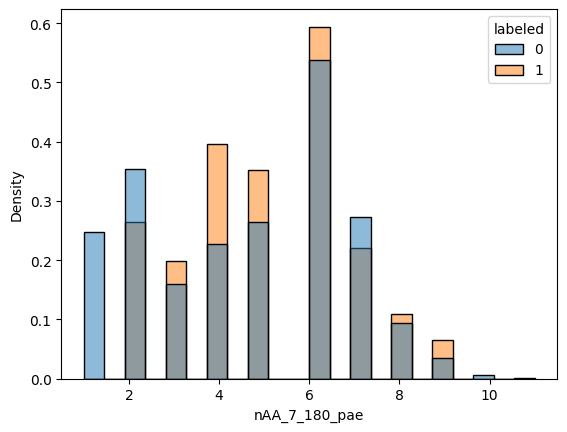

In [31]:
# visualize the distribution of crowdedness for a particular radius
col = 8
print(f"Visualizing Column: {cols_to_visualize[col]}")

temp_df = pd.DataFrame(data={cols_to_visualize[col]: np.concatenate((labeled[cols_to_visualize[col]].values, unlabeled[cols_to_visualize[col]].values)), "labeled": [1] * len(labeled) + [0] * len(unlabeled)})

sns.histplot(data=temp_df, x=cols_to_visualize[col], hue="labeled", stat="density", common_norm=False);

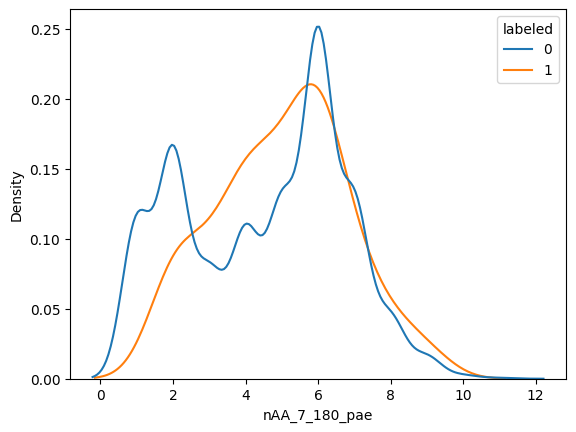

In [32]:
sns.kdeplot(data=temp_df, x=cols_to_visualize[col], bw_adjust=1, hue="labeled", common_norm=False);

<Axes: xlabel='nAA_7_180_pae'>

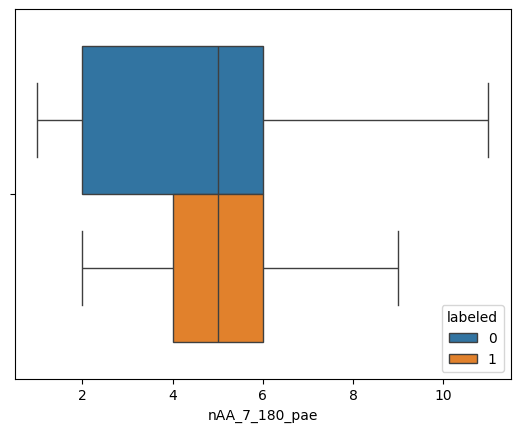

In [33]:
sns.boxplot(data=temp_df, x=cols_to_visualize[col], hue="labeled")